In [12]:
import pandas as pd
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Flatten, Activation, LSTM, Bidirectional, Add, SpatialDropout1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


In [13]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Paths
ravdess_speech_path = '/Users/yathamlohithreddy/Desktop/vscodefloder /marsproject/Audio_Speech_Actors_01-24'
ravdess_song_path   =  '/Users/yathamlohithreddy/Desktop/vscodefloder /marsproject/Audio_Song_Actors_01-24'

# Settings
max_len = 300
SAMPLE_RATE = 16000
sequences = []
labels = []

# Emotion map from RAVDESS (filename part 3: 03-01-XX-...)
ravdess_emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# === Load & Preprocess ===
def load_and_preprocess(file_path, sr=SAMPLE_RATE):
    y, _ = librosa.load(file_path, sr=sr)
    y, _ = librosa.effects.trim(y, top_db=30)
    y = y / np.max(np.abs(y)) if np.max(np.abs(y)) > 0 else y
    return y

# === Feature Extraction ===
def extract_features(y, sr):
    mfcc     = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    rolloff  = librosa.feature.spectral_rolloff(y=y, sr=sr)
    rms      = librosa.feature.rms(y=y)
    zcr      = librosa.feature.zero_crossing_rate(y=y)

    try:
        f0 = librosa.yin(y, sr=sr, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
        f0 = f0.reshape(1, -1)
    except:
        f0 = np.zeros((1, mfcc.shape[1]))

    T = mfcc.shape[1]
    def resize(f): return f[:, :T] if f.shape[1] >= T else np.pad(f, ((0, 0), (0, T - f.shape[1])))
    
    all_features = np.vstack([
        mfcc,
        resize(rolloff),
        resize(rms),
        resize(zcr),
        resize(f0)
    ])
    return all_features.T  # shape: (T, feature_dim)

# === Process RAVDESS Dataset ===
def process_ravdess(path, tag=""):
    count = 0
    for actor_folder in os.listdir(path):
        folder_path = os.path.join(path, actor_folder)
        if not os.path.isdir(folder_path):
            continue
        for file in os.listdir(folder_path):
            if not file.endswith(".wav"):
                continue
            parts = file.split("-")
            if len(parts) < 3:
                continue
            emotion_code = parts[2]
            label = ravdess_emotion_map.get(emotion_code)
            if not label:
                continue

            file_path = os.path.join(folder_path, file)
            y = load_and_preprocess(file_path)
            features = extract_features(y, SAMPLE_RATE)

            sequences.append(features)
            labels.append(label)
            count += 1
    print(f"✔️ {tag} - Loaded {count} samples")

# Process both datasets
process_ravdess(ravdess_speech_path, tag="Speech")
process_ravdess(ravdess_song_path, tag="Song")

# === Finalize ===
X = pad_sequences(sequences, maxlen=max_len, dtype='float32', padding='post', truncating='post')
le = LabelEncoder()
y = le.fit_transform(labels)

# === Summary ===
print("✅ Total samples (RAVDESS Speech + Song):", len(labels))
print("✅ X shape:", X.shape)   # (samples, max_len, features)
print("✅ y shape:", y.shape)   # (samples,)

print("\nEmotion label mapping:")
for idx, emotion in enumerate(le.classes_):
    print(f"  {idx} → {emotion}")


✔️ Speech - Loaded 1440 samples
✔️ Song - Loaded 1012 samples
✅ Total samples (RAVDESS Speech + Song): 2452
✅ X shape: (2452, 300, 17)
✅ y shape: (2452,)

Emotion label mapping:
  0 → angry
  1 → calm
  2 → disgust
  3 → fearful
  4 → happy
  5 → neutral
  6 → sad
  7 → surprised


In [14]:
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)

In [15]:
# suppose X.shape == (n_samples, timesteps, feat_dim)
n_samples, timesteps, feat_dim = X_train.shape

# 1) flatten
X_flat = X_train.reshape(n_samples, timesteps * feat_dim)

# 2) resample
smote = SMOTE(random_state=42)
X_flat_res, y_res = smote.fit_resample(X_flat, y_train)

# 3) reshape back to sequences
n_resampled = X_flat_res.shape[0]
X_res = X_flat_res.reshape(n_resampled, timesteps, feat_dim)

print("Resampled shapes:", X_res.shape, y_res.shape)

Resampled shapes: (2440, 300, 17) (2440,)


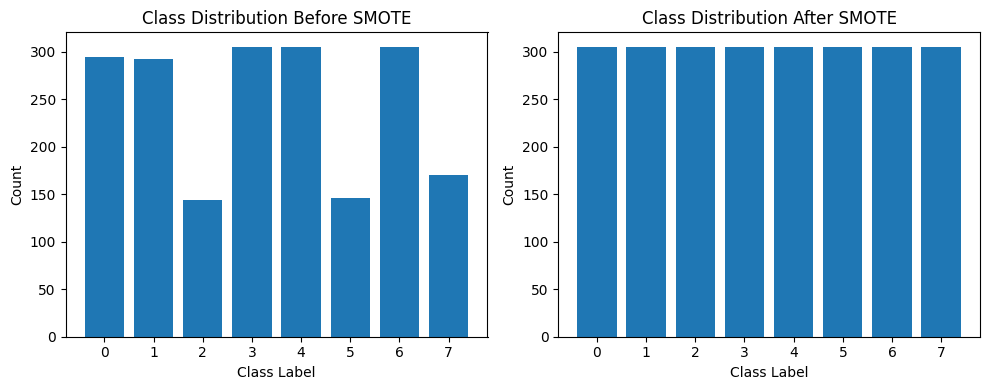

In [16]:
# If y and y_resampled are Series, convert to arrays:
# y_orig = y.values
# y_res = y_resampled.values
import matplotlib.pyplot as plt


y_orig = np.array(y_train)
y_resampled  = np.array(y_res)

# Get sorted list of classes
classes = np.unique(y_orig)

# Count occurrences
counts_before = [(y_orig == cls).sum() for cls in classes]
counts_after  = [(y_resampled  == cls).sum() for cls in classes]

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].bar(classes, counts_before)
axes[0].set_title('Class Distribution Before SMOTE')
axes[0].set_xlabel('Class Label')
axes[0].set_ylabel('Count')

axes[1].bar(classes, counts_after)
axes[1].set_title('Class Distribution After SMOTE')
axes[1].set_xlabel('Class Label')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [17]:
def add_noise(X, noise_level=0.01):
    noise = np.random.normal(0, noise_level, X.shape)
    return X + noise

def random_time_scaling(X, scale_range=(0.9, 1.1)):
    scaled = []
    for seq in X:
        factor = np.random.uniform(*scale_range)
        scaled.append(seq * factor)
    return np.array(scaled)

def time_mask(X, max_mask_size=5):
    X_masked = X.copy()
    for i in range(X.shape[0]):
        t = np.random.randint(0, X.shape[1] - max_mask_size)
        X_masked[i, t:t+max_mask_size, :] = 0
    return X_masked

X_augmented_noise = add_noise(X_res)
X_augmented_scaled = random_time_scaling(X_res)
X_augmented_masked = time_mask(X_res)

X_aug = np.concatenate([X_res, X_augmented_noise, X_augmented_scaled, X_augmented_masked], axis=0)
y_aug = np.concatenate([y_res] * 4, axis=0)

print("Augmented shape:", X_aug.shape, y_aug.shape)

Augmented shape: (9760, 300, 17) (9760,)


In [18]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, SpatialDropout1D,
    GlobalAveragePooling1D, Dense
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import regularizers

# Define shape variables
num_emotions = len(np.unique(y_res))  # y_res: class labels
timesteps, feat_dim = X_aug.shape[1], X_aug.shape[2]  # X_aug: audio features

# Learning rate schedule
initial_learning_rate = 1e-4
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=False
)

# Build the model
model = Sequential([
    Input(shape=(timesteps, feat_dim)),

    Conv1D(128, kernel_size=9, activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    SpatialDropout1D(0.3),

    Conv1D(128, kernel_size=7, activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    SpatialDropout1D(0.3),

    Conv1D(128, kernel_size=5, activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    SpatialDropout1D(0.3),

    Conv1D(128, kernel_size=3, activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    SpatialDropout1D(0.3),

    Conv1D(64, kernel_size=1, activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    SpatialDropout1D(0.3),

    GlobalAveragePooling1D(),

    Dense(num_emotions, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 300, 128)       │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 300, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_5             │ (None, 300, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 300, 128)       │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 300, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_6             │ (None, 300, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 300, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 300, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_7             │ (None, 300, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 300, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 300, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_8             │ (None, 300, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 300, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 300, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_9             │ (None, 300, 64)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 276,936 (1.06 MB)

 Trainable params: 275,784 (1.05 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [19]:
print(y_aug)

[4 3 3 ... 7 7 7]


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint


checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

history = model.fit(
    X_aug, y_aug,
    validation_data=(X_val, y_val),
    epochs=120,
    batch_size=32,
    callbacks=[checkpoint]
)

Epoch 1/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.1301 - loss: 2.2243

305/305 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.1301 - loss: 2.2242 - val_accuracy: 0.1670 - val_loss: 2.0926
Epoch 2/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.1634 - loss: 2.1199

305/305 ━━━━━━━━━━━━━━━━━━━━ 29s 96ms/step - accuracy: 0.1635 - loss: 2.1199 - val_accuracy: 0.1670 - val_loss: 2.0545
Epoch 3/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 29s 94ms/step - accuracy: 0.2080 - loss: 2.0541 - val_accuracy: 0.1405 - val_loss: 2.0615
Epoch 4/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.2522 - loss: 1.9910

305/305 ━━━━━━━━━━━━━━━━━━━━ 29s 95ms/step - accuracy: 0.2523 - loss: 1.9909 - val_accuracy: 0.2525 - val_loss: 1.9137
Epoch 5/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.2924 - loss: 1.9197

305/305 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - accuracy: 0.2925 - loss: 1.9196 - val_accuracy: 0.2485 - val_loss: 1.8752
Epoch 6/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.3533 - loss: 1.8359

305/305 ━━━━━━━━━━━━━━━━━━━━ 31s 102ms/step - accuracy: 0.3532 - loss: 1.8359 - val_accuracy: 0.3136 - val_loss: 1.7982
Epoch 7/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 30s 98ms/step - accuracy: 0.3787 - loss: 1.7687 - val_accuracy: 0.2811 - val_loss: 1.8111
Epoch 8/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 30s 100ms/step - accuracy: 0.3929 - loss: 1.7176 - val_accuracy: 0.3279 - val_loss: 1.8743
Epoch 9/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.4196 - loss: 1.6713

305/305 ━━━━━━━━━━━━━━━━━━━━ 32s 105ms/step - accuracy: 0.4196 - loss: 1.6712 - val_accuracy: 0.3625 - val_loss: 1.6447
Epoch 10/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.4294 - loss: 1.6205

305/305 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.4295 - loss: 1.6204 - val_accuracy: 0.3605 - val_loss: 1.6309
Epoch 11/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 32s 106ms/step - accuracy: 0.4551 - loss: 1.5740 - val_accuracy: 0.3523 - val_loss: 1.6476
Epoch 12/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.4747 - loss: 1.5257 - val_accuracy: 0.3747 - val_loss: 1.6398
Epoch 13/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4856 - loss: 1.4860

305/305 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.4856 - loss: 1.4860 - val_accuracy: 0.3931 - val_loss: 1.5656
Epoch 14/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.4897 - loss: 1.4651

305/305 ━━━━━━━━━━━━━━━━━━━━ 28s 92ms/step - accuracy: 0.4897 - loss: 1.4650 - val_accuracy: 0.4012 - val_loss: 1.5567
Epoch 15/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5077 - loss: 1.4163

305/305 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step - accuracy: 0.5077 - loss: 1.4163 - val_accuracy: 0.4175 - val_loss: 1.4828
Epoch 16/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5149 - loss: 1.4019

305/305 ━━━━━━━━━━━━━━━━━━━━ 29s 94ms/step - accuracy: 0.5149 - loss: 1.4018 - val_accuracy: 0.4114 - val_loss: 1.4771
Epoch 17/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.5272 - loss: 1.3648 - val_accuracy: 0.3971 - val_loss: 1.5417
Epoch 18/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.5256 - loss: 1.3583 - val_accuracy: 0.4094 - val_loss: 1.4955
Epoch 19/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - accuracy: 0.5351 - loss: 1.3215 - val_accuracy: 0.4114 - val_loss: 1.4793
Epoch 20/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5493 - loss: 1.3034

305/305 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.5493 - loss: 1.3034 - val_accuracy: 0.4277 - val_loss: 1.4362
Epoch 21/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - accuracy: 0.5470 - loss: 1.2914 - val_accuracy: 0.4073 - val_loss: 1.5043
Epoch 22/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5630 - loss: 1.2588

305/305 ━━━━━━━━━━━━━━━━━━━━ 28s 92ms/step - accuracy: 0.5630 - loss: 1.2588 - val_accuracy: 0.4318 - val_loss: 1.4344
Epoch 23/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - accuracy: 0.5711 - loss: 1.2537 - val_accuracy: 0.4216 - val_loss: 1.4687
Epoch 24/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 29s 95ms/step - accuracy: 0.5691 - loss: 1.2280 - val_accuracy: 0.4175 - val_loss: 1.4822
Epoch 25/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - accuracy: 0.5787 - loss: 1.2140 - val_accuracy: 0.4460 - val_loss: 1.4456
Epoch 26/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5910 - loss: 1.1818

305/305 ━━━━━━━━━━━━━━━━━━━━ 29s 95ms/step - accuracy: 0.5909 - loss: 1.1818 - val_accuracy: 0.4338 - val_loss: 1.4238
Epoch 27/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.5800 - loss: 1.1964

305/305 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.5800 - loss: 1.1964 - val_accuracy: 0.4216 - val_loss: 1.4110
Epoch 28/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5941 - loss: 1.1625

305/305 ━━━━━━━━━━━━━━━━━━━━ 30s 97ms/step - accuracy: 0.5941 - loss: 1.1626 - val_accuracy: 0.4745 - val_loss: 1.3410
Epoch 29/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5921 - loss: 1.1633

305/305 ━━━━━━━━━━━━━━━━━━━━ 30s 98ms/step - accuracy: 0.5921 - loss: 1.1633 - val_accuracy: 0.4786 - val_loss: 1.3336
Epoch 30/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 30s 98ms/step - accuracy: 0.6052 - loss: 1.1476 - val_accuracy: 0.4562 - val_loss: 1.3741
Epoch 31/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 30s 97ms/step - accuracy: 0.6016 - loss: 1.1517 - val_accuracy: 0.4582 - val_loss: 1.3611
Epoch 32/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 30s 97ms/step - accuracy: 0.6100 - loss: 1.1208 - val_accuracy: 0.4542 - val_loss: 1.3876
Epoch 33/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 29s 97ms/step - accuracy: 0.6259 - loss: 1.0932 - val_accuracy: 0.4420 - val_loss: 1.3884
Epoch 34/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 30s 99ms/step - accuracy: 0.6115 - loss: 1.1078 - val_accuracy: 0.4481 - val_loss: 1.3878
Epoch 35/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 30s 100ms/step - accuracy: 0.6187 - loss: 1.1053 - val_accuracy: 0.4582 - val_loss: 1.3490
Epoch 36/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 31s 102ms/step - accuracy: 0.6232 - loss: 1.08

305/305 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - accuracy: 0.6410 - loss: 1.0429 - val_accuracy: 0.4725 - val_loss: 1.3092
Epoch 41/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 25s 84ms/step - accuracy: 0.6324 - loss: 1.0479 - val_accuracy: 0.4847 - val_loss: 1.3246
Epoch 42/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.6345 - loss: 1.0388 - val_accuracy: 0.4542 - val_loss: 1.3828
Epoch 43/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 33s 109ms/step - accuracy: 0.6496 - loss: 1.0281 - val_accuracy: 0.4684 - val_loss: 1.3252
Epoch 44/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 34s 111ms/step - accuracy: 0.6389 - loss: 1.0405 - val_accuracy: 0.4644 - val_loss: 1.3556
Epoch 45/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6456 - loss: 1.0133

305/305 ━━━━━━━━━━━━━━━━━━━━ 32s 104ms/step - accuracy: 0.6456 - loss: 1.0134 - val_accuracy: 0.4807 - val_loss: 1.2958
Epoch 46/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - accuracy: 0.6549 - loss: 1.0083 - val_accuracy: 0.4582 - val_loss: 1.3559
Epoch 47/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 31s 101ms/step - accuracy: 0.6689 - loss: 0.9875 - val_accuracy: 0.4277 - val_loss: 1.4151
Epoch 48/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 30s 97ms/step - accuracy: 0.6615 - loss: 0.9825 - val_accuracy: 0.4684 - val_loss: 1.3105
Epoch 49/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6566 - loss: 1.0044

305/305 ━━━━━━━━━━━━━━━━━━━━ 30s 98ms/step - accuracy: 0.6567 - loss: 1.0043 - val_accuracy: 0.4990 - val_loss: 1.2538
Epoch 50/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 30s 98ms/step - accuracy: 0.6640 - loss: 0.9860 - val_accuracy: 0.4521 - val_loss: 1.3626
Epoch 51/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 31s 102ms/step - accuracy: 0.6750 - loss: 0.9741 - val_accuracy: 0.4888 - val_loss: 1.3263
Epoch 52/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 30s 99ms/step - accuracy: 0.6669 - loss: 0.9708 - val_accuracy: 0.4562 - val_loss: 1.3572
Epoch 53/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 31s 103ms/step - accuracy: 0.6671 - loss: 0.9641 - val_accuracy: 0.4664 - val_loss: 1.3368
Epoch 54/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 30s 100ms/step - accuracy: 0.6687 - loss: 0.9609 - val_accuracy: 0.4684 - val_loss: 1.3476
Epoch 55/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 30s 98ms/step - accuracy: 0.6727 - loss: 0.9576 - val_accuracy: 0.4745 - val_loss: 1.3102
Epoch 56/120
305/305 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.6711 - loss: 0.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


y_val_pred_probs = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)




# Accuracy
val_acc = accuracy_score(y_val, y_val_pred)


print(f"Validation Accuracy: {val_acc:.4f}")


# 2) Compute confusion matrices
cm_val = confusion_matrix(y_val, y_val_pred)
cm_val_norm = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]



class_names = list(le.classes_)
num_classes = len(class_names)
tick_marks = np.arange(num_classes)

fig, ax = plt.subplots(figsize=(8, 6))  # Adjust size as needed

# Confusion Matrix - Validation (Counts)
ax.imshow(cm_val, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title("Validation Confusion Matrix (Counts)")
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, format(cm_val[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm_val[i, j] > cm_val.max()/2 else "black")

plt.tight_layout()
plt.show()


# F1 Score (macro, weighted, etc.)
f1 = f1_score(y_val, y_val_pred, average='macro')
print(f"Macro F1-score: {f1:.4f}")

# Detailed report
print("\nClassification Report:\n")
print(classification_report(y_val, y_val_pred, target_names=class_names))


In [ ]:
import matplotlib.pyplot as plt

# Extract losses
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Extract losses
train_loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
